## Skorch GA network classification example

In [2]:
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.ga_nn import GAModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve, learning_curve



In [3]:
cancer_data = load_breast_cancer()
X, cancer_test, y, cancer_test_label = train_test_split(cancer_data.data, cancer_data.target, test_size=0.2, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

In [10]:
from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=GAModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=20,
    module__hidden_layers=3,
    module__population_size=300,
    module__to_mate=150,
    module__to_mutate=30,
    max_epochs=5,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # use nn.CrossEntropyLoss instead of default nn.NLLLoss
    # for use with raw prediction values instead of log probabilities
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
GAModule.register_ga_training_step()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)

Pipeline(steps=[('scale', StandardScaler()),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=GAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=30, out_features=20, bias=True)
      (1-3): 3 x Linear(in_features=20, out_features=20, bias=True)
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  ),
))])

In [8]:
from sklearn.model_selection import GridSearchCV


# module specific parameters need to begin with 'module__'
default_params = {
    'net__module__input_dim': [30],
    'net__module__output_dim': [2],
    'net__max_epochs': [5],
    'net__module__population_size': [300],
    'net__module__to_mate': [150],
}

grid_search_params = {
    # 'net__to_mutate': [30, 60],
    **default_params,
}

gs = GridSearchCV(pipe, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END net__max_epochs=5, net__module__input_dim=30, net__module__output_dim=2, net__module__population_size=300, net__module__to_mate=150; total time=   7.9s
[CV] END net__max_epochs=5, net__module__input_dim=30, net__module__output_dim=2, net__module__population_size=300, net__module__to_mate=150; total time=   7.1s
[CV] END net__max_epochs=5, net__module__input_dim=30, net__module__output_dim=2, net__module__population_size=300, net__module__to_mate=150; total time=   7.2s
best score: 0.358, best params: {'net__max_epochs': 5, 'net__module__input_dim': 30, 'net__module__output_dim': 2, 'net__module__population_size': 300, 'net__module__to_mate': 150}


## Plot learning curves

In [12]:
net.history[:, 'train_loss']

[0.7165863099989,
 0.7165862902180179,
 0.7165862997809609,
 0.7148114787353264,
 0.7148114419245458]

In [9]:
net.history

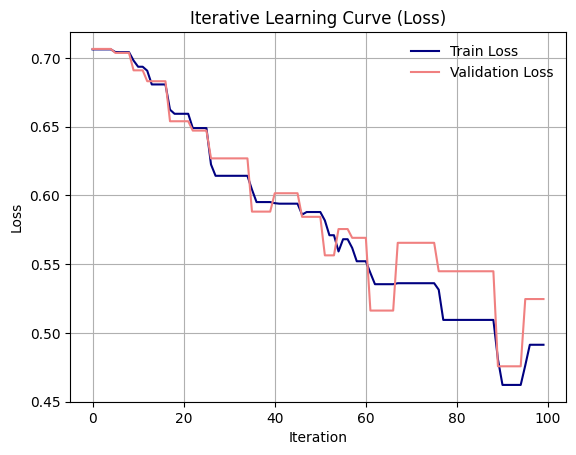

In [58]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

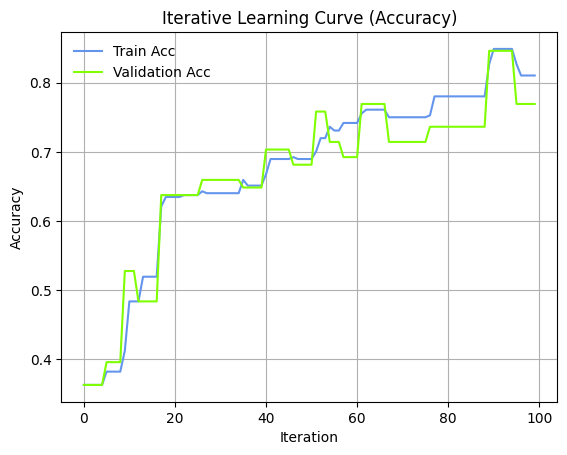

In [56]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn pipeline with RO

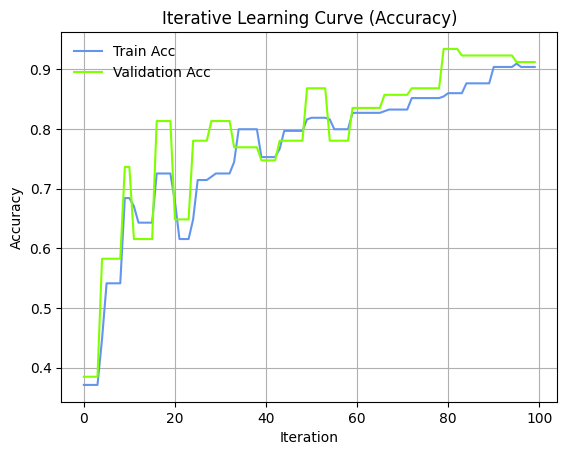

In [44]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)